# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
sum(data[data.race=='w'].call)

235.0

In [4]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


##### 1) What test is appropriate for this problem? Does CLT apply?

In [5]:
print("rows:", data.shape[0])

rows: 4870


All of the conditions for the CLT are met, since:
   - According to the study, researchers randomly assigned identical résumés to black-sounding or white-sounding names, so we can assume that the randomness and independence conditions are met.
   - The sample has more than 30 entries.

The appropriate test is a two-sample Z-test, where

<img src="z_test_proportion.png">

##### 2) What are the null and alternate hypotheses?

Null hypothesis: "race has not a significant impact on the rate of callbacks for resumes"

Alternate hypothesis: "race has a significant impact on the rate of callbacks for resumes"

test statistic: "proportion of callbacks"

##### 3) Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

In [6]:
w = data[data.race=='w']
b = data[data.race=='b']

Frequentist approach

In [7]:
# function for the calculation of the difference in proportions
def diff_frac(data_A, data_B):
    frac_A = np.sum(data_A) / len(data_A)
    frac_B = np.sum(data_B) / len(data_B)
    return frac_B - frac_A

# observed difference between proportions
obs_diff = diff_frac(b.call, w.call)
print("observed difference between proportions:", obs_diff)


# proportion (assuming H0)
p_hat = (np.sum(w.call) + np.sum(b.call)) / (len(w.call) + len(b.call))

# standard deviation of the difference of proportions
std = np.sqrt(p_hat*(1 - p_hat) * (1/len(w.call) + 1/len(b.call)))

# margin of error
margin_error = stats.norm.ppf(0.975) * std


# 95% confidence interval
c_interval_left = obs_diff - margin_error
c_interval_right = obs_diff + margin_error
print("\nThe confidence interval, for a level of significance of 5%, is [", c_interval_left,",", c_interval_right, "]")

# z-test
z_score = (obs_diff - 0) / std
print("The Z-score is", z_score)

# p-value
p_value = (1 - stats.norm.cdf(z_score)) * 2
print("The p-value is", p_value)

observed difference between proportions: 0.032032854209445585

The confidence interval, for a level of significance of 5%, is [ 0.01675122270727635 , 0.04731448571161482 ]
The Z-score is 4.108412152434346
The p-value is 3.983886837577444e-05


We can see that the p-value is extremely low, well below 0.05, so we have sufficient statistical evidence to reject the null hypothesis, which states that race has not a significant impact on the rate of callbacks for resumes.

Also, if we repeated the experiment over and over again, 95% of the difference between the proportions would stay on a positive interval, where 0 does not belong. Hence, we could also reject the null hypothesis given the computed confidence interval.

Bootstrapping approach

In [8]:
print("observed difference between proportions:", obs_diff)

# function for generating a permutation replicate
def permutation_sample(data1, data2):
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2

# Generating permutation replicates
def draw_perm_reps(data_1, data_2, func, size=1):
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

# 10000 permutation samples
perm_replicates = draw_perm_reps(b.call, w.call, diff_frac, 10000)    


# 95% confidence interval
conf_int = np.percentile(perm_replicates, [2.5, 97.5])
print('95% confidence interval for the replicas of the difference of proportions, assuming H0 =', conf_int)

# p-value
p_value = np.sum(perm_replicates >= obs_diff) / len(perm_replicates)
print('p-value =', p_value)

observed difference between proportions: 0.032032854209445585
95% confidence interval for the replicas of the difference of proportions, assuming H0 = [-0.01478439  0.01478439]
p-value = 0.0


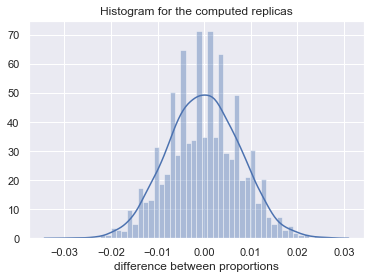

In [11]:
# histogram with a kernel density estimate
sns.distplot(perm_replicates)
plt.title("Histogram for the computed replicas")
plt.xlabel("difference between proportions")
plt.show()

We make the same conclusion as before: we reject the null hypothesis. We can see graphically that the probability of having a difference as the one observed is very low.

##### 4) Write a story describing the statistical significance in the context or the original problem.

The p-value we achieved is not only statistically significant, but almost null, and as a consequence race has a very significant impact on the rate of callbacks for resumes, where white-sounding names are much more privileged than black-sounding ones. Given this study, we can then confidently say that the level of racial discrimination in the United States labor market is high.

##### 5) Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

No, because we just examined that factor for callback success, all other variables being equal. The other ones like education, volunteering, sex or even the name on the e-mail could also have impact and be a motive for further study. Also, our conclusions might be different if we filtered our analysis by city, or education, for example. 

So, if the goal is to know the most important factor, one way of amending the analysis is performing more of those studies, starting with the ones would could likely have a higher impact, like education. 

In [10]:
# variables
print(data.columns)

Index(['id', 'ad', 'education', 'ofjobs', 'yearsexp', 'honors', 'volunteer',
       'military', 'empholes', 'occupspecific', 'occupbroad', 'workinschool',
       'email', 'computerskills', 'specialskills', 'firstname', 'sex', 'race',
       'h', 'l', 'call', 'city', 'kind', 'adid', 'fracblack', 'fracwhite',
       'lmedhhinc', 'fracdropout', 'fraccolp', 'linc', 'col', 'expminreq',
       'schoolreq', 'eoe', 'parent_sales', 'parent_emp', 'branch_sales',
       'branch_emp', 'fed', 'fracblack_empzip', 'fracwhite_empzip',
       'lmedhhinc_empzip', 'fracdropout_empzip', 'fraccolp_empzip',
       'linc_empzip', 'manager', 'supervisor', 'secretary', 'offsupport',
       'salesrep', 'retailsales', 'req', 'expreq', 'comreq', 'educreq',
       'compreq', 'orgreq', 'manuf', 'transcom', 'bankreal', 'trade',
       'busservice', 'othservice', 'missind', 'ownership'],
      dtype='object')
